### PART 1 (XGBoost)

Imports

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, r2_score as r2_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor

Load data

In [59]:
# Load data
df = pd.read_csv('quasars.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,21.438610,19.551710,18.458599,18.002470,17.684971,20.114059,18.123720,16.970390,16.529791,16.130140,0.147575
1,22.314270,21.104860,21.004841,21.159269,20.946699,18.455139,17.081511,16.702650,16.831730,16.627399,0.014620
2,23.585871,21.433531,20.224360,19.816570,19.820490,23.784389,21.429319,20.209129,19.806770,19.804779,-0.000360
3,19.402540,17.313789,16.431690,16.170959,16.002871,19.418880,17.314190,16.453730,16.165510,15.996530,0.000040
4,21.115400,20.218599,19.658670,19.515110,19.455120,21.103861,20.175430,19.659109,19.522350,19.480000,0.000317


Train/test split

In [60]:
# X is all columns except the last
X = df.drop(df.columns[-1], axis=1)

# y is the last column
y = df[df.columns[-1]]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

Fit XGBoost model + train/val split (90/10)

In [61]:
# Train model on 90 % of training data, use 10 % for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=0)

# Instantiate the Xgboost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    colsample_bytree=0.5, 
    learning_rate=0.1, 
    max_depth=4, 
    reg_lambda=1, 
    n_estimators=500, 
    eval_metric='rmse', 
    random_state=0)

# Train the model
eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.63478	validation_1-rmse:0.58782
[1]	validation_0-rmse:0.61853	validation_1-rmse:0.57116
[2]	validation_0-rmse:0.60529	validation_1-rmse:0.55767
[3]	validation_0-rmse:0.59391	validation_1-rmse:0.54591
[4]	validation_0-rmse:0.58338	validation_1-rmse:0.53471
[5]	validation_0-rmse:0.57571	validation_1-rmse:0.52786
[6]	validation_0-rmse:0.56913	validation_1-rmse:0.52136
[7]	validation_0-rmse:0.56250	validation_1-rmse:0.51414
[8]	validation_0-rmse:0.55706	validation_1-rmse:0.50894
[9]	validation_0-rmse:0.55151	validation_1-rmse:0.50402
[10]	validation_0-rmse:0.54709	validation_1-rmse:0.49933
[11]	validation_0-rmse:0.54357	validation_1-rmse:0.49545
[12]	validation_0-rmse:0.54028	validation_1-rmse:0.49184
[13]	validation_0-rmse:0.53725	validation_1-rmse:0.48892
[14]	validation_0-rmse:0.53499	validation_1-rmse:0.48750
[15]	validation_0-rmse:0.53271	validation_1-rmse:0.48469
[16]	validation_0-rmse:0.53038	validation_1-rmse:0.48235
[17]	validation_0-rmse:0.52867	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

Plotting train/val RMSE against boosting iterations

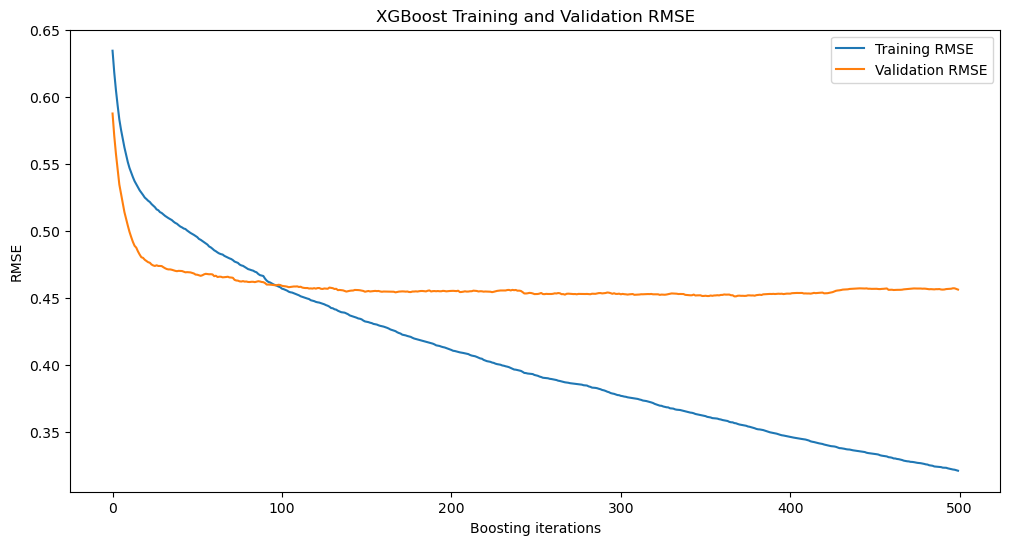

In [62]:
# Extract evaluation results
results = xgb_model.evals_result()

# Number of boosting iterations
epochs = len(results['validation_0']['rmse'])

# X-axis (boosting iterations)
x_axis = range(0, epochs)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Training RMSE')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation RMSE')
plt.legend()
plt.xlabel('Boosting iterations')
plt.ylabel('RMSE')
plt.title('XGBoost Training and Validation RMSE')
plt.show()

Test set predictions

In [63]:
# Test set predictions
y_pred = xgb_model.predict(X_test)

# Test set RMSE
rmse = np.sqrt(mse(y_test, y_pred))
print(f"Test set RMSE: {rmse}")

# Test set R2 score
r2 = r2_score(y_test, y_pred)
print(f"Test set R2 score: {r2}")

Test set RMSE: 0.4836191065895514
Test set R2 score: 0.4038644401242629


XGBoost with GridSearchCV

In [64]:
# Parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 500, 1000, 1500, 2000],
    'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.9],
    'reg_lambda': [1, 1.5, 2]
}

# Instantiate the Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit the Grid Search
grid_search.fit(X_train, y_train)

# Find the best parameters
grid_search.best_params_
print(grid_search.best_params_)

# Refit the model
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_best_xgb = best_xgb_model.predict(X_test)
rmse_best_xgb = np.sqrt(mse(y_test, y_pred_best_xgb))
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)
print(f"Test set RMSE: {rmse_best_xgb}")
print(f"Test set R2 score: {r2_best_xgb}")

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 1.5}
Test set RMSE: 0.46097496868556936
Test set R2 score: 0.45838234230255936


KNN comparison

In [65]:
# Compare with KNN model
knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
rmse_knn = np.sqrt(mse(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)
print(f"KNN test set RMSE: {rmse_knn}")
print(f"KNN test set R2 score: {r2_knn}")

KNN test set RMSE: 0.4810138290780895
KNN test set R2 score: 0.4102699573649706


In [66]:
# Performance comparison
print("Is XGBoost better than KNN (RMSE)?", rmse_best_xgb < rmse_knn)
print("Is XGBoost better than KNN (R2)?", r2_best_xgb > r2_knn)

Is XGBoost better than KNN (RMSE)? True
Is XGBoost better than KNN (R²)? True


### PART 2 (Stochastic Logistic Regression)

Load data

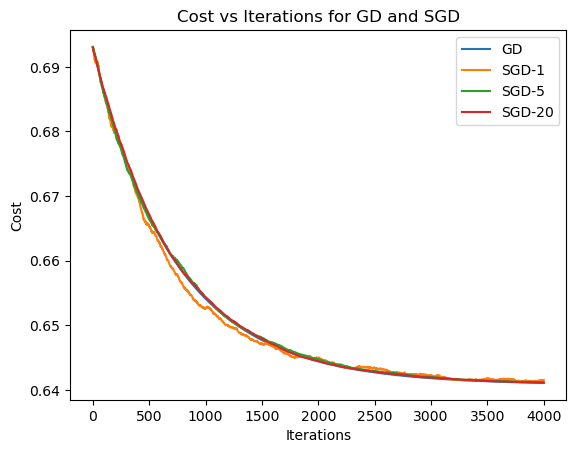

In [69]:
# Load X_data.csv and y_data.csv
X_data = pd.read_csv('X_data.csv', header=None)
y_data = pd.read_csv('y_data.csv', header=None)

# Convert to numpy arrays
X_data = X_data.to_numpy()
y_data = y_data.to_numpy().ravel()

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost function
def compute_cost(X, y, beta, lambd):
    m = len(y)
    z = np.dot(X, beta)
    cost = -1/m * np.sum(y * np.log(sigmoid(z)) + (1 - y) * np.log(1 - sigmoid(z)))
    reg_cost = cost + (lambd/2) * np.sum(np.square(beta))
    return reg_cost

# Gradient function
def compute_gradient(X, y, beta, lambd):
    m, n = X.shape
    z = np.dot(X, beta)
    gradient = 1/m * np.dot(X.T, (sigmoid(z) - y)) + lambd * beta
    return gradient

# Gradient descent
def gradient_descent(X, y, beta, learning_rate, iterations, lambd):
    cost_history = []
    for i in range(iterations):
        beta = beta - learning_rate * compute_gradient(X, y, beta, lambd)
        cost_history.append(compute_cost(X, y, beta, lambd))
    return beta, cost_history

# Stochastic Gradient Descent
def stochastic_gradient_descent(X, y, beta, learning_rate, iterations, lambd, batch_size):
    m, n = X.shape
    cost_history = []
    for i in range(iterations):
        idx = np.random.choice(m, batch_size, replace=False)
        X_batch = X.iloc[idx] if isinstance(X, pd.DataFrame) else X[idx]
        y_batch = y.iloc[idx] if isinstance(y, pd.DataFrame) else y[idx]
        beta = beta - learning_rate * compute_gradient(X_batch, y_batch, beta, lambd)
        cost_history.append(compute_cost(X, y, beta, lambd))
    return beta, cost_history

# Parameters
lambd = 5
learning_rate = 0.0001
iterations = 4000
beta_initial = np.zeros(X_data.shape[1])

# Run Gradient Descent
beta_gd, cost_gd = gradient_descent(X_data, y_data, beta_initial, learning_rate, iterations, lambd)

# Plot GD Cost Function
plt.plot(cost_gd, label='GD')

# Run Stochastic Gradient Descent for different mini-batch sizes
for batch_size in [1, 5, 20]:
    beta_sgd, cost_sgd = stochastic_gradient_descent(X_data, y_data, beta_initial, learning_rate, iterations, lambd, batch_size)
    plt.plot(cost_sgd, label=f'SGD-{batch_size}')

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations for GD and SGD')
plt.legend()
plt.show()

Show a zoom-in of the plot for the first 500 iterations and for last 500 iterations

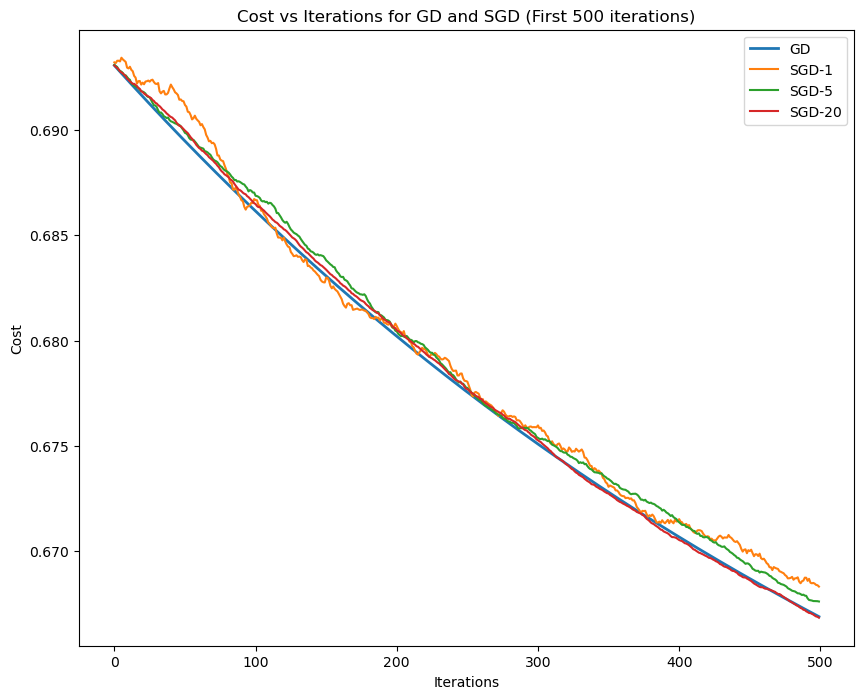

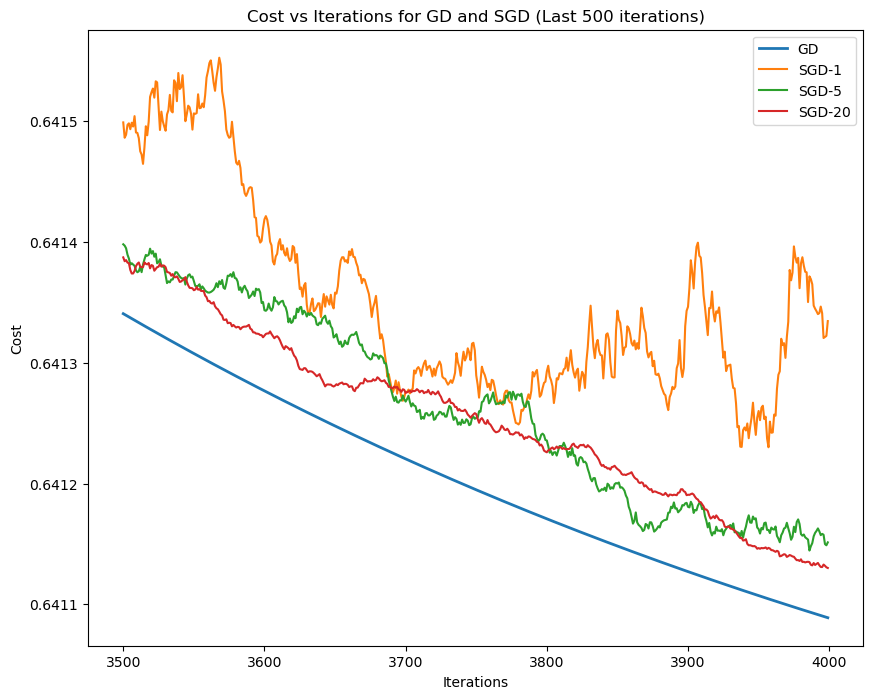

In [70]:
# Run Stochastic Gradient Descent for different mini-batch sizes and store costs
costs_sgd = {}
for batch_size in [1, 5, 20]:
    beta_sgd, cost_sgd = stochastic_gradient_descent(X_data, y_data, beta_initial, learning_rate, iterations, lambd, batch_size)
    costs_sgd[batch_size] = cost_sgd

# First 500 iterations plot
plt.figure(figsize=(10, 8))
plt.plot(cost_gd[:500], label='GD', linewidth=2)
for batch_size, cost in costs_sgd.items():
    plt.plot(cost[:500], label=f'SGD-{batch_size}')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations for GD and SGD (First 500 iterations)')
plt.legend()
plt.show()

# Last 500 iterations plot
plt.figure(figsize=(10, 8))
plt.plot(range(3500, 4000), cost_gd[-500:], label='GD', linewidth=2)
for batch_size, cost in costs_sgd.items():
    plt.plot(range(3500, 4000), cost[-500:], label=f'SGD-{batch_size}')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations for GD and SGD (Last 500 iterations)')
plt.legend()
plt.show()